In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from machines import mps_trotter
from machines import mps_utils
import utils
import scipy
import h5py

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


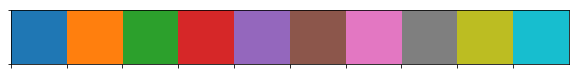

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

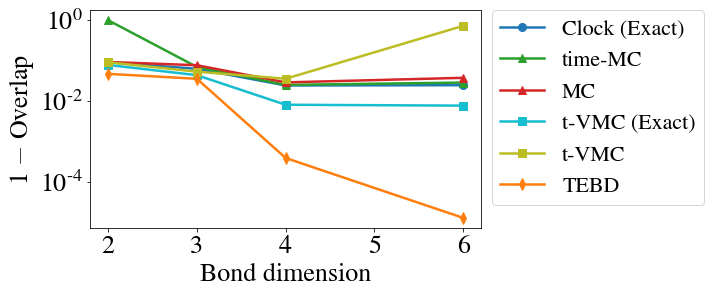

In [8]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
data_dir = "C:/DATA/ClockV2/histories"

time_steps = 20
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

bond_list = [2, 3, 4, 6]
overlaps = {"Clock (Exact)": [], "time-MC": [], "MC": [], "TEBD": []}
for d_bond in bond_list:
    trotter = mps_trotter.TFIM_TEBD(exact_state[0], d_bond, dt, h=h_ev)
    trotter_state = trotter.dense_evolution(time_steps)
    overlaps["TEBD"].append(utils.averaged_overlap(exact_state, trotter_state))
    
    #full = mps_trotter.TFIMFull(exact_state[0], d_bond, dt, h=h_ev)
    #full_state = full.dense_evolution(time_steps)
    #overlaps["Full"].append(utils.averaged_overlap(exact_state, full_state))
    
    clock_hist = h5py.File("{}/N={}/allstates_mpsD{}_N{}M{}.h5py".format(data_dir, n_sites, d_bond, n_sites, time_steps), "r")
    overlaps["Clock (Exact)"].append(clock_hist["avg_overlaps"][-1])
    clock_hist.close()
    
    clock_hist = h5py.File("{}/N={}/sampling20000_mpsD{}_N{}M{}.h5py".format(data_dir, n_sites, d_bond, n_sites, time_steps), "r")
    overlaps["time-MC"].append(clock_hist["overlaps"][-1])
    clock_hist.close()
    
    clock_hist = h5py.File("{}/N={}/spacesampling1000_mpsD{}_N{}M{}.h5py".format(data_dir, n_sites, d_bond, n_sites, time_steps), "r")
    overlaps["MC"].append(clock_hist["avg_overlaps"][-1])
    clock_hist.close()
    
tvmc_hist = h5py.File("{}/N={}/tvmc_allstates_mpsd2_6_N{}M{}.h5py".format(data_dir, n_sites, n_sites, time_steps), "r")
overlaps["t-VMC (Exact)"] = tvmc_hist["avg_overlaps"][()]
tvmc_hist.close()

tvmc_hist = h5py.File("{}/N={}/tvmc_sampling5000_mpsd2_6_N{}M{}.h5py".format(data_dir, n_sites, n_sites, time_steps), "r")
overlaps["t-VMC"] = tvmc_hist["avg_overlaps"][()]
tvmc_hist.close()

plt.figure(figsize=(7, 4))
#plt.title("MPS, $N={}$, $T={}$".format(n_sites, time_steps))
plot_list = [("Clock (Exact)", "o", cp[0]), ("time-MC", "^", cp[2]), ("MC", "^", cp[3]), 
             ("t-VMC (Exact)", "s", cp[-1]), ("t-VMC", "s", cp[-2]),
             ("TEBD", "d", cp[1])]
for k, m, c in plot_list:
    plt.semilogy(bond_list, 1 - np.array(overlaps[k]), color=c, marker=m, markersize=8, linewidth=2.5, label=k)
plt.xlabel("Bond dimension")
plt.ylabel("1 $-$ Overlap")
#plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.6), fontsize=22)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1.05), fontsize=22)
plt.show()
#plt.savefig("overlap_clock_tebd.pdf", bbox_inches='tight')

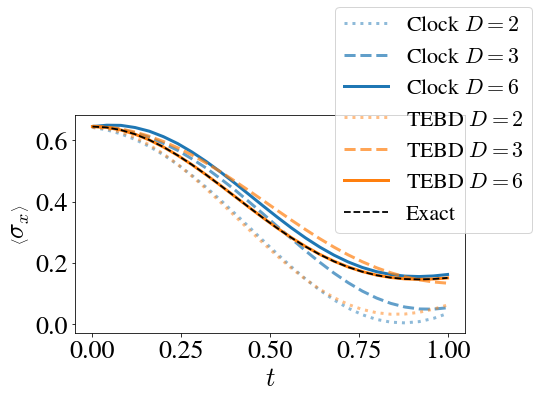

In [15]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
time_steps = 25
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
data_dir = "C:/DATA/ClockV2/final_dense"

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
pauli = utils.Pauli(dtype=exact_state.dtype)
obs_X = {}

for d_bond in [2, 3, 6]:
    trotter = mps_trotter.TFIM_TEBD(exact_state[0], d_bond, dt, h=h_ev)
    trotter_state = trotter.dense_evolution(time_steps)
    obs_X["TEBD $D={}$".format(d_bond)] = utils.ev_local(trotter_state, pauli.X)

    clock_state = np.load("{}/allstates_mpsD{}_N{}M{}.npy".format(data_dir, d_bond, n_sites, time_steps))
    obs_X["Clock $D={}$".format(d_bond)] = utils.ev_local(clock_state, pauli.X)

plt.figure(figsize=(7, 4))
#plt.title("MPS $N={}$, $T={}$".format(d_bond, n_sites, time_steps))
plot_list = [("Clock $D=2$", cp[0], 0.5, ":"), ("Clock $D=3$", cp[0], 0.7, "--"), ("Clock $D=6$", cp[0], 1.0, "-"),
             ("TEBD $D=2$", cp[1], 0.5, ":"), ("TEBD $D=3$", cp[1], 0.7, "--"), ("TEBD $D=6$", cp[1], 1.0, "-")]
for k, c, a, l in plot_list:
    plt.plot(t, obs_X[k].real, alpha=a, color=c, linewidth=3.0, label=k, linestyle=l)
plt.plot(t, exact_obs["X"].real, "--", color="black", linewidth=1.8, label="Exact")
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.55), fontsize=22)
#plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.05), fontsize=22)
plt.show()
#plt.savefig("sigma_x_clock_tebd.pdf", bbox_inches='tight')

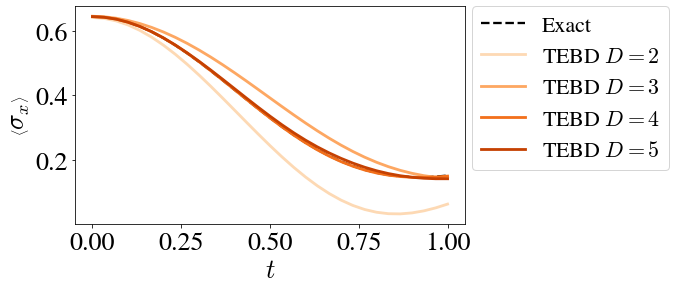

In [5]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
time_steps = 30
t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
data_dir = "D:/ClockV2/final_dense"

exact_state, exact_obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
pauli = utils.Pauli(dtype=exact_state.dtype)
obs_X = {}

for d_bond in [2, 3, 4, 5]:
    trotter = mps_trotter.TFIM_TEBD(exact_state[0], d_bond, dt, h=h_ev)
    trotter_state = trotter.dense_evolution(time_steps)
    obs_X["TEBD $D={}$".format(d_bond)] = utils.ev_local(trotter_state, pauli.X)

plt.figure(figsize=(7, 4))
#plt.title("MPS $N={}$, $T={}$".format(d_bond, n_sites, time_steps))
plt.plot(t, exact_obs["X"].real, "--", color="black", linewidth=2.3, label="Exact")

cseq = sns.color_palette("Oranges", len(obs_X))
for i, k in enumerate(obs_X.keys()):
    plt.plot(t, obs_X[k].real, color=cseq[i], linewidth=2.8, label=k)
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.05), fontsize=22)
plt.show()
#plt.savefig("sigma_x_clock_trotter.pdf", bbox_inches='tight')